<a href="https://colab.research.google.com/github/Harshil1010/IISC_test/blob/main/q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class PatchEmbedding(nn.Module):
    """
    Converts images into patches and projects them to embedding dimension
    """
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=512):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        # Convolution layer to extract patches and project to embedding dimension
        self.proj = nn.Conv2d(in_channels, embed_dim,
                             kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x shape: (batch_size, 3, 32, 32)
        x = self.proj(x)  # (batch_size, embed_dim, num_patches_h, num_patches_w)
        x = x.flatten(2)  # (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (batch_size, num_patches, embed_dim)
        return x

In [4]:
class MultiHeadSelfAttention(nn.Module):
    """
    Multi-Head Self Attention mechanism
    """
    def __init__(self, embed_dim=512, num_heads=8, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert self.head_dim * num_heads == embed_dim, "Embed dim must be divisible by num_heads"

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)  # Query, Key, Value
        self.attn_dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # Generate Q, K, V
        qkv = self.qkv(x).reshape(batch_size, num_tokens, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, batch_size, num_heads, num_tokens, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Scaled dot-product attention
        attn_scores = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_probs = F.softmax(attn_scores, dim=-1)
        attn_probs = self.attn_dropout(attn_probs)

        # Apply attention to values
        x = (attn_probs @ v).transpose(1, 2).reshape(batch_size, num_tokens, embed_dim)
        x = self.proj(x)
        x = self.proj_dropout(x)
        return x

In [5]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron (Feed-Forward Network)
    """
    def __init__(self, in_features, hidden_features, out_features, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerEncoderBlock(nn.Module):
    """
    Single Transformer Encoder Block (MHSA + MLP with residuals and layer norm)
    """
    def __init__(self, embed_dim=512, num_heads=8, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)

        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = MLP(embed_dim, mlp_hidden_dim, embed_dim, dropout)

    def forward(self, x):
        # Multi-Head Self Attention with residual connection
        x = x + self.attn(self.norm1(x))
        # MLP with residual connection
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    """
    Complete Vision Transformer model
    """
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
                 embed_dim=512, depth=6, num_heads=8, mlp_ratio=4, dropout=0.1):
        super().__init__()

        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches

        # CLS token and positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_dropout = nn.Dropout(dropout)

        # Transformer encoder blocks
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])

        # Layer norm and classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        # Initialize CLS token and positional embeddings
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

        # Initialize linear layers
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.trunc_normal_(module.weight, std=0.02)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

    def forward(self, x):
        batch_size = x.shape[0]

        # Patch embedding
        x = self.patch_embed(x)  # (batch_size, num_patches, embed_dim)

        # Add CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # (batch_size, num_patches + 1, embed_dim)

        # Add positional embeddings
        x = x + self.pos_embed
        x = self.pos_dropout(x)

        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x)

        # Final layer norm
        x = self.norm(x)

        # Use CLS token for classification
        cls_token_final = x[:, 0]  # Take the CLS token
        output = self.head(cls_token_final)

        return output

In [6]:
def get_data_loaders(batch_size=128):
    """
    Prepare CIFAR-10 dataset with data augmentation
    """
    # Data augmentation for training
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # Basic transform for testing
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # Download and load datasets
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=2)

    return train_loader, test_loader

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
def train_model(model, train_loader, test_loader, epochs=50, lr=0.001):
    """
    Training loop for the Vision Transformer
    """
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg Loss': f'{running_loss/(batch_idx+1):.4f}'
            })

        # Calculate average training loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on test set
        test_accuracy = evaluate_model(model, test_loader)
        test_accuracies.append(test_accuracy)

        # Update learning rate
        scheduler.step()

        print(f'Epoch [{epoch+1}/{epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Test Accuracy: {test_accuracy:.2f}%')

    return train_losses, test_accuracies

def evaluate_model(model, test_loader):
    """
    Evaluate the model on test set
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

100%|██████████| 170M/170M [03:06<00:00, 914kB/s]


Model has 18,979,338 parameters


Epoch 1/50: 100%|██████████| 391/391 [02:00<00:00,  3.25it/s, Loss=1.9552, Avg Loss=2.0105]


Epoch [1/50], Train Loss: 2.0105, Test Accuracy: 28.11%


Epoch 2/50: 100%|██████████| 391/391 [02:06<00:00,  3.08it/s, Loss=2.1311, Avg Loss=1.9439]


Epoch [2/50], Train Loss: 1.9439, Test Accuracy: 22.72%


Epoch 3/50: 100%|██████████| 391/391 [02:06<00:00,  3.08it/s, Loss=1.9375, Avg Loss=1.9943]


Epoch [3/50], Train Loss: 1.9943, Test Accuracy: 23.71%


Epoch 4/50: 100%|██████████| 391/391 [02:06<00:00,  3.09it/s, Loss=2.0038, Avg Loss=1.9900]


Epoch [4/50], Train Loss: 1.9900, Test Accuracy: 24.44%


Epoch 5/50: 100%|██████████| 391/391 [02:06<00:00,  3.08it/s, Loss=2.1093, Avg Loss=1.9857]


Epoch [5/50], Train Loss: 1.9857, Test Accuracy: 24.75%


Epoch 6/50: 100%|██████████| 391/391 [02:06<00:00,  3.09it/s, Loss=1.8696, Avg Loss=1.9698]


Epoch [6/50], Train Loss: 1.9698, Test Accuracy: 24.35%


Epoch 7/50: 100%|██████████| 391/391 [02:06<00:00,  3.10it/s, Loss=1.9908, Avg Loss=1.9770]


Epoch [7/50], Train Loss: 1.9770, Test Accuracy: 26.52%


Epoch 8/50: 100%|██████████| 391/391 [02:06<00:00,  3.10it/s, Loss=1.9182, Avg Loss=1.9612]


Epoch [8/50], Train Loss: 1.9612, Test Accuracy: 26.87%


Epoch 9/50: 100%|██████████| 391/391 [02:05<00:00,  3.11it/s, Loss=2.0436, Avg Loss=1.9536]


Epoch [9/50], Train Loss: 1.9536, Test Accuracy: 24.50%


Epoch 10/50: 100%|██████████| 391/391 [02:05<00:00,  3.10it/s, Loss=2.1003, Avg Loss=1.9498]


Epoch [10/50], Train Loss: 1.9498, Test Accuracy: 25.70%


Epoch 11/50: 100%|██████████| 391/391 [02:05<00:00,  3.11it/s, Loss=2.0431, Avg Loss=1.9426]


Epoch [11/50], Train Loss: 1.9426, Test Accuracy: 27.21%


Epoch 12/50: 100%|██████████| 391/391 [02:05<00:00,  3.12it/s, Loss=1.9302, Avg Loss=1.9552]


Epoch [12/50], Train Loss: 1.9552, Test Accuracy: 26.25%


Epoch 13/50: 100%|██████████| 391/391 [02:05<00:00,  3.12it/s, Loss=1.8938, Avg Loss=1.9315]


Epoch [13/50], Train Loss: 1.9315, Test Accuracy: 25.25%


Epoch 14/50: 100%|██████████| 391/391 [02:05<00:00,  3.12it/s, Loss=1.9765, Avg Loss=1.9178]


Epoch [14/50], Train Loss: 1.9178, Test Accuracy: 25.58%


Epoch 15/50: 100%|██████████| 391/391 [02:05<00:00,  3.12it/s, Loss=1.9305, Avg Loss=1.9136]


Epoch [15/50], Train Loss: 1.9136, Test Accuracy: 25.48%


Epoch 16/50: 100%|██████████| 391/391 [02:05<00:00,  3.12it/s, Loss=1.9274, Avg Loss=1.9072]


Epoch [16/50], Train Loss: 1.9072, Test Accuracy: 25.11%


Epoch 17/50: 100%|██████████| 391/391 [02:05<00:00,  3.12it/s, Loss=1.8803, Avg Loss=1.9205]


Epoch [17/50], Train Loss: 1.9205, Test Accuracy: 23.07%


Epoch 18/50: 100%|██████████| 391/391 [02:05<00:00,  3.12it/s, Loss=2.0339, Avg Loss=1.9367]


Epoch [18/50], Train Loss: 1.9367, Test Accuracy: 25.95%


Epoch 19/50: 100%|██████████| 391/391 [02:05<00:00,  3.12it/s, Loss=1.9612, Avg Loss=2.0202]


Epoch [19/50], Train Loss: 2.0202, Test Accuracy: 24.56%


Epoch 20/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=2.0475, Avg Loss=1.9929]


Epoch [20/50], Train Loss: 1.9929, Test Accuracy: 25.83%


Epoch 21/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=1.9493, Avg Loss=1.9830]


Epoch [21/50], Train Loss: 1.9830, Test Accuracy: 26.60%


Epoch 22/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=1.9687, Avg Loss=1.9777]


Epoch [22/50], Train Loss: 1.9777, Test Accuracy: 25.98%


Epoch 23/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=2.0713, Avg Loss=1.9753]


Epoch [23/50], Train Loss: 1.9753, Test Accuracy: 25.14%


Epoch 24/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=1.8901, Avg Loss=1.9766]


Epoch [24/50], Train Loss: 1.9766, Test Accuracy: 25.49%


Epoch 25/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=2.0072, Avg Loss=1.9795]


Epoch [25/50], Train Loss: 1.9795, Test Accuracy: 25.38%


Epoch 26/50: 100%|██████████| 391/391 [02:04<00:00,  3.13it/s, Loss=1.9825, Avg Loss=1.9684]


Epoch [26/50], Train Loss: 1.9684, Test Accuracy: 25.38%


Epoch 27/50: 100%|██████████| 391/391 [02:04<00:00,  3.13it/s, Loss=2.0247, Avg Loss=1.9626]


Epoch [27/50], Train Loss: 1.9626, Test Accuracy: 26.08%


Epoch 28/50: 100%|██████████| 391/391 [02:04<00:00,  3.13it/s, Loss=1.8662, Avg Loss=1.9583]


Epoch [28/50], Train Loss: 1.9583, Test Accuracy: 25.57%


Epoch 29/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=1.9318, Avg Loss=1.9555]


Epoch [29/50], Train Loss: 1.9555, Test Accuracy: 24.87%


Epoch 30/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=1.9807, Avg Loss=1.9492]


Epoch [30/50], Train Loss: 1.9492, Test Accuracy: 25.34%


Epoch 31/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=1.9216, Avg Loss=1.9416]


Epoch [31/50], Train Loss: 1.9416, Test Accuracy: 25.47%


Epoch 32/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=1.9435, Avg Loss=1.9444]


Epoch [32/50], Train Loss: 1.9444, Test Accuracy: 26.41%


Epoch 33/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=1.9790, Avg Loss=1.9396]


Epoch [33/50], Train Loss: 1.9396, Test Accuracy: 25.82%


Epoch 34/50: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s, Loss=1.8706, Avg Loss=1.9350]


Epoch [34/50], Train Loss: 1.9350, Test Accuracy: 25.13%


Epoch 35/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=1.9543, Avg Loss=1.9333]


Epoch [35/50], Train Loss: 1.9333, Test Accuracy: 25.93%


Epoch 36/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=1.8414, Avg Loss=1.9261]


Epoch [36/50], Train Loss: 1.9261, Test Accuracy: 26.48%


Epoch 37/50: 100%|██████████| 391/391 [02:04<00:00,  3.13it/s, Loss=1.8899, Avg Loss=1.9249]


Epoch [37/50], Train Loss: 1.9249, Test Accuracy: 27.29%


Epoch 38/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=2.1122, Avg Loss=1.9226]


Epoch [38/50], Train Loss: 1.9226, Test Accuracy: 27.15%


Epoch 39/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=1.8475, Avg Loss=1.9228]


Epoch [39/50], Train Loss: 1.9228, Test Accuracy: 27.07%


Epoch 40/50: 100%|██████████| 391/391 [02:04<00:00,  3.13it/s, Loss=1.8170, Avg Loss=1.9184]


Epoch [40/50], Train Loss: 1.9184, Test Accuracy: 27.59%


Epoch 41/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=1.9469, Avg Loss=1.9176]


Epoch [41/50], Train Loss: 1.9176, Test Accuracy: 26.19%


Epoch 42/50: 100%|██████████| 391/391 [02:04<00:00,  3.13it/s, Loss=1.8362, Avg Loss=1.9109]


Epoch [42/50], Train Loss: 1.9109, Test Accuracy: 27.47%


Epoch 43/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=1.8165, Avg Loss=1.9087]


Epoch [43/50], Train Loss: 1.9087, Test Accuracy: 27.46%


Epoch 44/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=1.7989, Avg Loss=1.9076]


Epoch [44/50], Train Loss: 1.9076, Test Accuracy: 27.71%


Epoch 45/50: 100%|██████████| 391/391 [02:04<00:00,  3.13it/s, Loss=1.9634, Avg Loss=1.9088]


Epoch [45/50], Train Loss: 1.9088, Test Accuracy: 27.41%


Epoch 46/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=1.9255, Avg Loss=1.9057]


Epoch [46/50], Train Loss: 1.9057, Test Accuracy: 27.24%


Epoch 47/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=1.9939, Avg Loss=1.9045]


Epoch [47/50], Train Loss: 1.9045, Test Accuracy: 27.67%


Epoch 48/50: 100%|██████████| 391/391 [02:04<00:00,  3.13it/s, Loss=1.8895, Avg Loss=1.9035]


Epoch [48/50], Train Loss: 1.9035, Test Accuracy: 27.70%


Epoch 49/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=1.8311, Avg Loss=1.9021]


Epoch [49/50], Train Loss: 1.9021, Test Accuracy: 27.58%


Epoch 50/50: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=2.0432, Avg Loss=1.9049]


Epoch [50/50], Train Loss: 1.9049, Test Accuracy: 27.63%


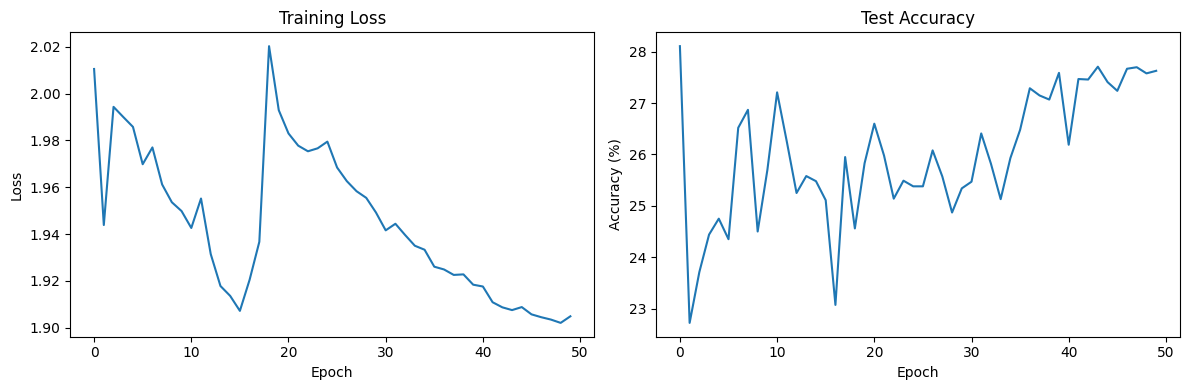

Final Test Accuracy: 27.63%


In [8]:
def main():
    # Hyperparameters
    batch_size = 128
    epochs = 50
    learning_rate = 0.001

    # Get data loaders
    train_loader, test_loader = get_data_loaders(batch_size)

    # Initialize model
    model = VisionTransformer(
        img_size=32,
        patch_size=4,           # 4x4 patches -> 8x8 = 64 patches
        in_channels=3,
        num_classes=10,
        embed_dim=512,          # Embedding dimension
        depth=6,                # Number of transformer blocks
        num_heads=8,            # Number of attention heads
        mlp_ratio=4,            # MLP expansion ratio
        dropout=0.1
    ).to(device)

    print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

    # Train the model
    train_losses, test_accuracies = train_model(
        model, train_loader, test_loader, epochs, learning_rate
    )

    # Plot results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()

    # Final evaluation
    final_accuracy = evaluate_model(model, test_loader)
    print(f"Final Test Accuracy: {final_accuracy:.2f}%")

if __name__ == "__main__":
    main()

In [9]:
class ImprovedViT(VisionTransformer):
    """
    Improved ViT with additional techniques for better performance
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Additional regularization: stochastic depth
        self.stochastic_depth = nn.Dropout(0.1)

    def forward(self, x):
        batch_size = x.shape[0]

        # Patch embedding
        x = self.patch_embed(x)

        # Add CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add positional embeddings
        x = x + self.pos_embed
        x = self.pos_dropout(x)

        # Pass through transformer blocks with stochastic depth
        for i, block in enumerate(self.blocks):
            # Apply stochastic depth (skip connections with probability)
            if self.training and torch.rand(1).item() < 0.1:
                continue
            x = block(x)
        # Final layer norm
        x = self.norm(x)

        # Use CLS token for classification
        cls_token_final = x[:, 0]
        output = self.head(cls_token_final)

        return output

# Advanced training with learning rate warmup
def train_with_warmup(model, train_loader, test_loader, epochs=50, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    # Warmup scheduler
    warmup_epochs = 5
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr, epochs=epochs,
        steps_per_epoch=len(train_loader)
    )

    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        test_accuracy = evaluate_model(model, test_loader)
        test_accuracies.append(test_accuracy)

        print(f'Epoch [{epoch+1}/{epochs}], '
              f'Loss: {avg_train_loss:.4f}, '
              f'Accuracy: {test_accuracy:.2f}%')

    return train_losses, test_accuracies

